In [324]:
import requests
from bs4 import BeautifulSoup
from urllib.parse import urljoin
from urllib.request import urlopen
import pandas as pd
import numpy as np
import pytesseract
import cv2

In [325]:
pytesseract.pytesseract.tesseract_cmd = r'C:\Program Files\Tesseract-OCR\tesseract.exe'

In [326]:
URL = "https://www.installateurs-zonnepanelen.nl/"

In [327]:
province_list = ["Drenthe", "Flevoland", "Friesland", "Gelderland", "Groningen", "Limburg", "Noord-Brabant", "Noord-Holland", "Overijssel", "Utrecht", "Zeeland", "Zuid-Holland"]

In [328]:
ext_list_province = []

In [329]:
for province in province_list:
    ext = "index.php?provincie={}&offset=".format(province)
    ext_list_province.append(ext)


In [330]:
testurl = URL +'/' +province_list[0] +'/'+ ext_list_province[0] + "0"

In [331]:
testurl

'https://www.installateurs-zonnepanelen.nl//Drenthe/index.php?provincie=Drenthe&offset=0'

In [332]:
page = requests.get(testurl)
soup = BeautifulSoup(page.content, 'html.parser')

In [333]:
lister = soup.find_all('a', string="Meer informatie")

In [334]:
href = lister[0].get('href')

In [335]:
href

'../bedrijf-Zonnepanelen+Noord_2912'

In [336]:
url_join = urljoin(testurl, href)

In [337]:
url_join

'https://www.installateurs-zonnepanelen.nl/bedrijf-Zonnepanelen+Noord_2912'

In [338]:
soup2 = BeautifulSoup(requests.get(url_join).content, 'html.parser')

In [339]:
soup2

<!DOCTYPE html>
 <!--[if lt IE 7]>		<html class="no-js lt-ie9 lt-ie8 lt-ie7" lang=""> <![endif]--> <!--[if IE 7]>			<html class="no-js lt-ie9 lt-ie8" lang=""> <![endif]--> <!--[if IE 8]>			<html class="no-js lt-ie9" lang=""> <![endif]--> <!--[if gt IE 8]><!--> <html class="no-js" lang=""> <!--<![endif]--> <head> <meta charset="utf-8"/> <meta content="IE=edge" http-equiv="X-UA-Compatible"/> <title> Zonnepanelen Noord | info + reviews [ 2023 ]</title> <meta content="Zonnepanelen Noord is de specialist in zonne-energie voor Noord Nederland wij adviseren, leveren en installeren zonnepanelen van A tot Z." name="description"/> <meta content="width=device-width, initial-scale=1" name="viewport"/>
<!--<link rel="apple-touch-icon" href="images/ico.png">--> <link href="images/ico.png" rel="icon" type="image/ico"/>
<link href="css/bootstrap.min.css" rel="stylesheet"/>
<link href="css/normalize.css" rel="stylesheet"/>
<link href="css/font-awesome.min.css" rel="stylesheet"/>
<link href="css/lineari

In [340]:
name = soup2.find_all('div', class_="tg-pagetitle")[0].text


In [341]:
filter_function_email = lambda tag: (
    tag.get('src', '').startswith('captcha')
)

In [342]:
email = soup2.find_all(filter_function_email)

In [343]:
email[0]

<img alt="" src="captcha_image.php?id=2912"/>

In [344]:
email_image_url = urljoin(URL, email[0].get('src'))

In [345]:
email_image_url

'https://www.installateurs-zonnepanelen.nl/captcha_image.php?id=2912'

In [346]:
image_url = email_image_url

In [347]:
from PIL import Image

In [348]:
def preprocessing(image):
    #convert to PIL image
    img = Image.fromarray(image)
    datas = img.getdata()
    newData = []
    for item in datas:
        if item[0] >= 200 and item[1] >= 200 and item[2] >= 200:
            newData.append((255, 255, 255, 0))
        else:
            newData.append(item)
    img.putdata(newData)
    return img

In [349]:
def image_url_to_text(url):
    response = requests.get(url)
    if response.status_code == 200:
        # Convert the image content to a NumPy array
        image_data = np.frombuffer(response.content, np.uint8)
    
        # Read the image using OpenCV
        image = cv2.imdecode(image_data, cv2.IMREAD_COLOR)
        #preprocess
        image = preprocessing(image)
        #convert to text
        text = pytesseract.image_to_string(image, lang='nld')
        return text
    else:
        return "Error"

In [350]:
response = requests.get(email_image_url)

In [351]:
image_data = np.frombuffer(response.content, np.uint8)
image = preprocessing(cv2.imdecode(image_data, cv2.IMREAD_COLOR))

In [352]:
import matplotlib.pyplot as plt

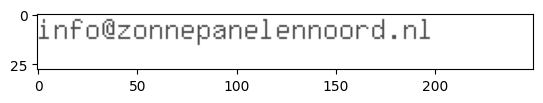

In [353]:
#display image
plt.imshow(image)


In [354]:
email_text = image_url_to_text(email_image_url)

In [355]:
email_text

'info@zonnepanelennoord.nl\n'

In [356]:
contact = soup2.find('ul', class_="tg-contactinfo")

In [357]:
#info page of company
def contact_loop(contact_object):
    address = None
    phone = None
    email = None
    for li in contact_object.find_all('li'):
        #print class of li children i tags
        if (li.i == None):
            continue
        class_name = li.i.get('class')[1]
        match class_name:
            case 'lnr-location':
                address = li.text
            case 'lnr-phone-handset':
                phone = li.text
                #clean phone number
                phone = phone.replace(' ', '')
            case 'lnr-envelope':
                email_url_ext = li.find('img').get('src')
                email_url = urljoin(URL, email_url_ext)
                email = image_url_to_text(email_url)
                email = email.replace('\n', '')
    return address, phone, email

In [491]:
company_df = pd.DataFrame(columns=['name', 'address', 'phone', 'email'])

In [492]:
offset_max = 1000
#loop over all provinces
for ind, ext in enumerate(ext_list_province):
    #loop over all pages offset of 8
    offset = 0 
    while offset < offset_max:
        page_url = URL + province_list[ind] + "/" + ext + "{}".format(offset)
        page = requests.get(page_url)
        soup = BeautifulSoup(page.content, 'html.parser')
        #list of companies on page
        lister = soup.find_all('a', string="Meer informatie")
        #check if lister is empty
        if len(lister) == 0:
            break
        #loop over all companies on page
        for company in lister:
            href = company.get('href')
            url_join = urljoin(page_url, href)
            soup_info_page = BeautifulSoup(requests.get(url_join).content, 'html.parser')
            contact = soup_info_page.find('ul', class_="tg-contactinfo")
            #get contact info of company
            name = soup_info_page.find_all('div', class_="tg-pagetitle")[0].text
            address, phone, email = contact_loop(contact)
            #append to dataframe
            print(name, address, phone, email)
            company_df = pd.concat([company_df, pd.DataFrame([[name, address, phone, email]], columns=['name', 'address', 'phone', 'email'])])
        offset += 8


 Zonnepanelen Noord    Compagnonsweg 1D, 9482 WR Tynaarlo  0592201372 info@zonnepanelennoord.nl
 Meppelink - Thuis in warmte    Industrieweg 9, 7903 AH Hoogeveen  0528262557 info@meppelink-thuisinwarmte.nl
 OUXO ENERGY    Exportweg 6, 9482 WP Tynaarlo  +31(0)853035328 info@ouxo.nl
 Installatiebedrijf Jansen Meppelink B.V.    Kleine Veld 15, 7751 BG Dalen  0524558280 info@ jansenmeppelink.nl
 NoCo2    Nijbracht 148, 7821 CE Emmen  0591820252 info@nocoë.nl
 De Groot Installatiegroep    Phileas Foggstraat 8, 7821 AK Emmen  0591613344 info@degrootgroep.nl
 Veldkamp installatie Techniek    Roegoorn 10, 9403 NP Assen  0592345773 None
 Langeland-Borgman    Krimweg 34B, 7741 KJ Coevorden  0524512886 info@langelandborgman.nl
 Eshuis Installatietechniek    Voltastraat 30, 7903 AB Hoogeveen  0528263410 infoBeshuis-wams.nl
 Techniko Ekehaar    Hoofdstraat 35, 9454 PK Ekehaar  0592389343 infoêtechniko.nl
 Dries Rolde    Gieterstraat 51, 9451 TE Rolde  0592242154 info@driesrolde.nl
 Waardevolt    Ho

In [493]:
#save to csv
company_df.to_csv('company_info_raw.csv')

In [568]:
company_df = pd.read_csv('./Data/installateurs-zonnepanelen.nl/company_info_raw.csv')

In [572]:
company_df['email'] = company_df['email'].astype(str)

In [574]:
#lower case and remove spaces
company_df['email'] = company_df['email'].str.lower()
company_df['email'] = company_df['email'].str.replace(' ', '')
company_df['email'] = company_df['email'].str.replace(',', '.')
company_df['email'] = company_df['email'].str.replace('‚', '.')




In [581]:
import re
 
# Make a regular expression
# for validating an Email
regex = r'\b[A-Za-z0-9._%+-]+@[A-Za-z0-9.-]+\.[A-Z|a-z]{2,7}\b'
 
# Define a function for
# for validating an Email
def check(email):
    if (email == 'nan'):
        return True
    # pass the regular expression
    # and the string into the fullmatch() method
    if(re.fullmatch(regex, email)):
        return True
    else:
        return False

In [582]:
filter_mask = company_df['email'].apply(check)
inverse_mask = np.invert(filter_mask)

In [583]:
wrong_df = company_df[inverse_mask]

In [584]:
wrong_df

,name,address,phone,email
4,NoCo2,"Nijbracht 148, 7821 CE Emmen",0591820252,info@nocoë.nl
8,Eshuis Installatietechniek,"Voltastraat 30, 7903 AB Hoogeveen",0528263410,infobeshuis-wams.nl
9,Techniko Ekehaar,"Hoofdstraat 35, 9454 PK Ekehaar",0592389343,infoêtechniko.nl
12,Technisch InstallatieBuro Woortman & Woortman...,"Bloemakkers 41, 9461 GX Gieten",0592265888,infoêtihwoortman.nl
19,Van Luik Installatietechniek,"Weerdingerstraat 198, 7822 BK Emmen",0591611310,info@vanluikinstallatietechniek
...,...,...,...,...
1376,Paans,"Nijverheidstraat 37, 4143 HN Leerdam",0302610111,info@paans„nl
1386,Solar-systemen Goedereede,"Waterpoort 20, 3252 CS Goedereede",06-53188170,rotterdamêsolar-systemen.nl
1387,Solaris-Energiesystemen,"Cypergras 213, 2498 CB Den Haag",0645466498,robin@solaris-energiesystemen.n.
1393,TI,"Bedrijfsstraat 3 - A, 3284 KB Zuid Beijerland",+31186661533,infoêtielemaninstallatie.nl


In [588]:
corrected_emails = [
    'info@nocoë.nl', 'info@beshuis-wams.nl', 'info@techniko.nl',
    'info@tihwoortman.nl', 'info@vanluikinstallatietechniek.nl',
    'woon.slimmebatherm.nl', 'info@vanriesen-installatietechn.nl',
    'info@technischburohoving.nl', 'info@energietref.nl',
    'info@telektrotechniek-emmen.nl', 'info@leco-systemen.nl',
    'info@redasolar.nl', 'info@energiewonen.nl', 'info@lagrienergie.nl',
    'info@teertinkbv.nl', 'j.looman@hetnet.nl', 'info@hetzonnedak.nl',
    'info@zon.nl', 'info@hi-sneek.nl', 'info@ib-spoelstra.nl',
    'info@energieservice.nl', 'info@lewald.nl',
    'info@bakker-installatiebedrijf.nl', 'sythol@hetnet.nl',
    'info@alsmatechniek.nl', 'info@installatiebedrijfvanderhe.nl',
    'info@ec-solar.nl', 'info@hetenergieloket.com',
    't.wielinga@installatiebedrijf-w.nl', 'info@evo-energie.nl',
    'info@obbink-installatietechniek.nl', 'info@atlaspower.nl',
    'info@revabv.eu', 'hollandgaatduurzaam@gmail.com',
    'contact@beterduurzaam.nl', 'info@draaijerinstallatietechniel.nl',
    'info@telroduurzamedaken.nl', 'rozon@rzze.nl',
    'info@detbvandebeek.nl', 'info@mvanmeurs.nl', 'office@del-tec.nl',
    'info@fenat.nl', 'info@kruisselbrinkinstallaties.nl',
    'info@trintech.nl', 'info@vandiepeninstallatietechni.nl',
    'info@tesdoetinchem.nl', 'henkjan@installatiebedrijfmuis.nl',
    'info@dijkerman-lammers.nl', 'info@entensolar.nl',
    'info@ten-hove.nl', 'info@lestrade.nl',
    'info@loodgietersbedrijfadekker.nl', 'info@deruijterinstallatie.nl',
    'info@teefting-epse.nl', 'info@foosterhoffpoolen.nl',
    'info@coenders-installatietechni.nl', 'info@tenergywonder.nl',
    'info@installatiebedrijfvannorel.nl', 'info@leertouwer.nl',
    'info@rufra.nl', 'veerman@veermaninstallatiebedri.nl',
    'info@heine-elektrotechniek.nl', 'info@installatietechnieknijkerk.nl',
    'klantenservice@zonadviesnederla.nl', 'info@hooymans.com',
    'info@installatiebedrijfbeumkes.nl', 'info@techcore.nl',
    'info@fat-elektrotechniek.nl', 'info@tenhoveinstallateurs.nl',
    'info@ethwakkermans.nl', 'info@teindelijkzon.nl',
    'peter@ambagtsheer.eu', 'info@bartsinstallatietechniek.nl',
    'info@electrisun.nl', 'info@reith.nl',
    'info@elkink-installatiebedrijf.nl', 'info@energieplusdak.nl',
    'info@charliebunt.nl', 'info@gbrightgreensolutions.nl',
    'info@ezenergie.nl', 'info@ezenergie.nl', 'info@elektrobv.nl',
    'info@elektrokass.nl', 'info@hellosun.nl',
    'info@installatietechniekbouwhee.nl', 'info@refu-tiel.nl',
    'info@sfi.nl', 'huizebrink@hetnet.nl',
    'info@koster-installatietechniek.nl',
    'info@becker-installatietechniek.nl',
    'info@faenainstallatietechniek.nl',
    'info@derksinstallatietechniek.nl', 'info@byssuszonnepanelenmontage.nl',
    'info@fenie.nl', 'info@kuipersinstallatiebedrijf.nl',
    'info@energieremmers.nl', 'info@scheepstra-installatiebedr.nl',
    'klaasoorburg@gmail.com', 'info@telektrotechniekgroningen.nl',
    'info@telize.nl', 'info@westra-installatietechniek.nl',
    'info@energiegoed.com', 'info@koningstotaalinstallateurs.nl',
    'info@reindersinstallatietechniel.nl', 'info@tib.nl',
    'info@gnewenergysystems.nl', 'info@elektro-scheppers.com',
    'info@elektrokersten.nl', 'info@petecsolar.com',
    'info@telektrovangach.nl', 'pw@zongarant.com',
    'info@telektro-theunissen.nl', 'info@installatiebedrijfvleeshou.nl',
    'info@tvkdakwerken.nl', 'info@epm.nl', 'info@haltronic.nl',
    'info@installatiebedrijfpeeters.nl', 'info@sydasolar.nl',
    'info@telektrototaalservice.nl', 'info@ecogetechnics.nl',
    'contact@haja-energy.nl', 'mp@invent-solutions.nl',
    'info@energa.nl', 'info@energierijk.com', 'info@delm-ia.nl',
    'info@xperal.com', 'info@solarline.nl',
    'info@eigenenergie.net', 'info@evansantvoort.nl',
    'info@laerspire.com', 'info@helios-solar.nl',
    'info@loodgietersbedrijfpeelen.nl', 'udenhout@hoppenbrouwers.nl',
    'info@energieverdieners.nl', 'info@testilburg.nl',
    'info@installatiebedrijfvanhilst.nl', 'info@van-hout.com',
    'narion@ruissen.info', 'info@stravensinstallatietechniel.nl',
    'info@thijssenelektro.nl', 'stelwagenjr@hotmail.com',
    'info@ibispower.eu', 'info@installatiebedrijfdenissen.nl',
    'info@vanpuijenbroek.com', 'info@lajloots.nl', 'bredatelektravon.nl',
    'info@ebtechniekgroep.nl', 'info@installatiebedrijfvandeven.nl',
    'info@heuvel-elektrotechniek.nl', 'info@installatiebedrijfvdgoorbe.nl',
    'info@tegelie.nl', 'info@energieanders.nl', 'info@epbelektro.nl',
    'info@helderzon.nl', 'info@installatiebedrijffranken.nl',
    'info@bergelektro.nl', 'eindhoven@zu.nl',
    'info@rj-installatie.nl', 'info@solartechniekbrabant.net',
    'info@turific.nl', 'o-lwxs.nl',
    'info@dewitinstallatietechniek.nl', 'info@telektropartners.nl',
    'info@udegraafelektrotechniek.nl', 'info@ib-hoffer.nl',
    'info@beerepootinstallatietechni.nl', 'info@rood.nl', 'info@loit.nl',
    'vragendenergieinhuis.nl', 'info@lammers-toepoel.nl',
    'info@waterlandinstallatietechni.nl', 'info@zwarttechniek.com',
    'info@expertsolarsystems.nl', 'bevelsen@tele2.nl',
    'sales@zonnecollectoren-zonnepan.nl',
    'info@hottingelektrotechniek.nl',
    'info@duurzame-installatietechni.nl', 'info@jans2on.nl',
    'konings@koningselektrotechniek.nl', 'info@texel4trading.nl',
    'info@zonne-energie-westfrieslan.nl',
    'zonnepanelenwestfriesland@live.nl',
    'info@installatiebedrijfvanleuss.nl', 'info@dekkerelektrotechniek.com',
    'info@schlepers-installatietechn.nl', 'info@lavandijk.nl',
    'klantenservice@energie-control.nl', 'info@schulte-energie-techniek.nl',
    'info@nijhof-broekland.nl', 'info@rouwenhorstinstallatiet.nl',
    'info@troost-installatie.nl', 'socialmedia@nefit.nl',
    'info@elektrohan.nl', 'info@installatiebedrijf-veldhui.nl',
    'info@energiewacht.nl', 'info@tegelsdakbedekking.nl',
    'contact@zonnepanelen-overijssel.nl', 'info@lagro-nrg.nl',
    'info@aannemersbedrijftempelman.nl', 'info@energieplein.nl',
    'info@fp4all.com', 'info@installatietechniek-groen.nl',
    'info@klasterinstallatietechniek.nl', 'info@meuleman-elektrotechniek.nl',
    'info@expertsolarsystems.nl', 'info@tsbvalk.nl',
    'info@vanderweerdelektrotechniek.nl', 'info@techtron.nl',
    'info@huiberselectra.nl', 'info@vandenpol.com', 'info@hil-trade.nl',
    'info@hedo.nu', 'info@enersolar.nl', 'info@devreeden.nl',
    'info@telektroclaus.nl', 'ilse@elektrob.nl',
    'info@installatiebedrijfmoesberg.nl',
    'info@heinenhopmaninstallaties.nl', 'info@hofland-installaties.nl',
    'info@rhijnenvechtstreek.nl', 'info@eviax.nl',
    'info@vanschaikelektrotechniek.nl', 'info@hitonline.nl',
    'info@elektroned.nl', 'info@telektrovdberg.nl',
    'info@vanginkelenergietechniek.nl', 'info@zondermeer.com',
    'post@installatiebedrijfdevisser.nl',
    'info@installatiebedrijf-bevelan.nl', 'algemeen@vanoosteninstallatie.nl',
    'algemeen@holbv.nl', 'info@etbhogenes.nl', 'info@zpvlnl.nl',
    'info@tibdeboer.nl', 'info@tuinreconstructie.nl', 'info@tethdenoord.nl',
    'install.vonk@gmail.com', 'info@energyguards.nl',
    'info@vanwijngaardenelektrotechn.nl', 'info@hallostroom.nl',
    'pietfrancken@hotmail.com', 'ron@energiehuisvanburen.nl',
    'vgs@hetnet.nl', 'info@loodgietersbedrijfvanputte.nl',
    'info@thyser.com', 'info@brouwerinstallatiebedrijf.nl',
    'info@sprong-installatietechniek.nl', 'info@opgewekt-energie.net',
    'info@hennink.info', 'info@hoogendoornelektrotechniek.nl',
    'info@oudshoorn-elektrotechniek.nl', 'info@beyerinstallatie.nl',
    'info@neeleman.com', 'info@expirion.nl',
    'info@esi-elektrotechniek.nl', 'info@elektroteylingen.nl',
    'info@ensysenergie.nl', 'info@heko.nl', 'info@tanelektro.com',
    'info@installatietechniekgresnig.nl', 'info@zonnepanelenmontagebedrijf.nl',
    'rotterdam@zu.nl', 'info@nestorservice.nl', 'info@oosterbouw.nl',
    'info@paans.nl', 'rotterdam@solar-systemen.nl',
    'robin@solaris-energiesystemen.nl', 'info@tielemaninstallatie.nl',
    'info@zonnepanelengoedkoopkopen.nl'
]


In [589]:
from difflib import SequenceMatcher

In [590]:
def similar(a, b):
    return SequenceMatcher(None, a, b).ratio()

In [600]:
for index, row in wrong_df.iterrows():
    for email in corrected_emails:
        if (similar(row['email'], email) > 0.9):
            wrong_df.at[index, 'email_corrected'] = email
            break

In [603]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

In [605]:
corrected_df = wrong_df[['name', 'address', 'phone', 'email_corrected']]

In [607]:
corrected_df.columns = ['name', 'address', 'phone', 'email']

In [609]:
#join corrected_df and company_df
company_df_complete = pd.concat([company_df[filter_mask], corrected_df])

In [611]:
company_df_complete['email'] = company_df_complete['email'].str.lower()

In [613]:
company_df_complete.to_csv('company_info_cleaned.csv')